This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is an big dataset that combines 3 hospitals (143,104,118) previously used by retain, after excluding the last visit, there are 114,630 patients in total with visits/codes history
* The logistic regression model has the architecture of an embedding layer (embedding dimension =1), a linear activation and sigmoid transformation
* Our model achieves overall 0.7555 test auc (visits < 5: 0.7275 test auc, visit >= 5: 0.7826 test auc), with corresponding 0.7584 validation auc on epoch 4
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce     

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(folder = 'data2/cerner/hospital_data/', hosp_list=[143,104,118], test_r=0.2 , valid_r=0.1):

   merged_set=[]
   for h in hosp_list:
       seqFile= folder+'h'+str(h)+'.visits'
       labelFile= folder+'h'+str(h)+'.labels'
       set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
       set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
       #merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       merged_set_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       merged_set_h =[x for x in merged_set_f if len(x[1])>0]

       merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [6]:
train1 , valid1, test1 = data_load_split_VT()
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

80241 11463 22926


In [7]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[360, 379, 62, 63], [4902, 5117, 57, 252, 449, 379, 62, 63]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [375, 83, 84, 63, 1250, 83, 84, 63, 195, 1250, 83, 84, 63, 1536, 83, 84, 63, 622, 68, 1632, 3059, 83, 84, 63, 1429, 622, 1756, 1306, 703, 354, 83, 84, 63, 8827, 559, 475, 83, 84, 63, 872, 83, 84, 63, 1250, 83, 84, 63]]
[0, [12, 195, 134, 16, 196, 186, 656, 198, 187, 188, 74, 550, 31, 8, 102, 35, 37, 540, 572, 356, 228, 879, 196, 260, 10, 6, 8, 188, 74, 6, 8]]
[0, [88, 16, 157, 158, 198, 91, 22, 165, 166, 96, 135, 167, 901, 1970, 31, 137, 139, 226, 102, 172, 958, 356, 175, 1102, 266, 880, 88, 157, 139, 156, 88, 16, 157, 198, 161, 22, 23, 165, 1259, 260, 223, 166, 167, 136, 29, 855, 1910, 31, 139, 101, 171, 172, 49, 175, 880, 88, 4884, 31, 12, 88, 134, 16, 2, 1270, 158, 23, 165, 1259, 223, 166, 1970, 31, 226, 101, 1

In [8]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
-1.0475e-01
-1.4093e-01
 2.4824e+00
     ⋮      
-5.2047e-01
 3.9847e-01
-1.2217e+00
[torch.FloatTensor of size 20000x1]

        emb                           types
0 -0.104750                            Code
1 -0.140932  b'M_ACETAMINOPHEN-HYDROCODONE'
2  2.482399         b'M_BACITRACIN TOPICAL'
3 -2.913580    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.189581                  b'M_CEFAZOLIN'


In [9]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.4792795291881645


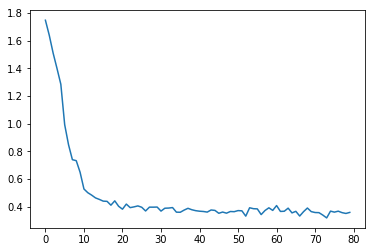

Epoch  0 Summary:  Training_auc : 0.5638406047452627  , Validation_auc :  0.5503974333292223  ,Test_auc :  0.575624759707097 Test_auc on short visits: 0.5940154930629586 Test_auc on long visits: 0.5644294791050392  Avg Loss:  0.4792795291881645 Train Time (2m 12s) Eval Time (1m 21s)

 Current running on: Epoch  1 Training loss:  Average loss 0.3461274099386401


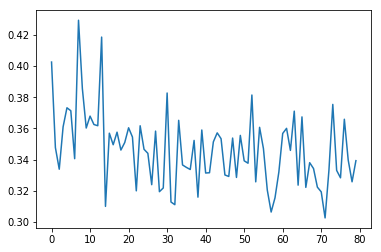

Epoch  1 Summary:  Training_auc : 0.7559266844973256  , Validation_auc :  0.7501924076332863  ,Test_auc :  0.7525575318821102 Test_auc on short visits: 0.7228046155882903 Test_auc on long visits: 0.7816442616861615  Avg Loss:  0.3461274099386401 Train Time (2m 15s) Eval Time (1m 18s)

 Current running on: Epoch  2 Training loss:  Average loss 0.33383088492646723


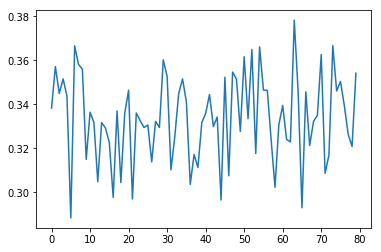

Epoch  2 Summary:  Training_auc : 0.756808533365487  , Validation_auc :  0.7500643022175711  ,Test_auc :  0.7542204121486202 Test_auc on short visits: 0.7292299192022114 Test_auc on long visits: 0.7779077896268816  Avg Loss:  0.33383088492646723 Train Time (2m 16s) Eval Time (1m 26s)

 Current running on: Epoch  3 Training loss:  Average loss 0.33234432531264685


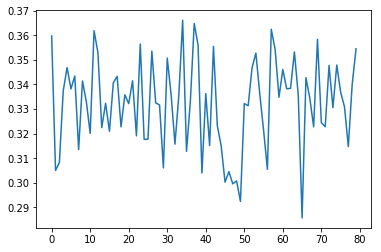

Epoch  3 Summary:  Training_auc : 0.7590589529748872  , Validation_auc :  0.7551801424486597  ,Test_auc :  0.7547018630458192 Test_auc on short visits: 0.7289575454733909 Test_auc on long visits: 0.7788229033421751  Avg Loss:  0.33234432531264685 Train Time (2m 20s) Eval Time (1m 27s)

 Current running on: Epoch  4 Training loss:  Average loss 0.331548232628917


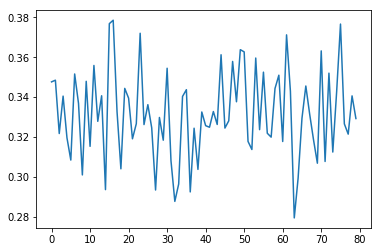

Epoch  4 Summary:  Training_auc : 0.764304105244145  , Validation_auc :  0.7583784648879238  ,Test_auc :  0.7554868321329793 Test_auc on short visits: 0.7275150253614562 Test_auc on long visits: 0.7825779048357714  Avg Loss:  0.331548232628917 Train Time (2m 52s) Eval Time (1m 12s)

 Current running on: Epoch  5 Training loss:  Average loss 0.3312393354986285


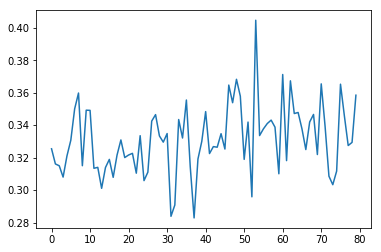

Epoch  5 Summary:  Training_auc : 0.7637006973193776  , Validation_auc :  0.7572902817392395  ,Test_auc :  0.7573301115371369 Test_auc on short visits: 0.7288319126096541 Test_auc on long visits: 0.7838581026774103  Avg Loss:  0.3312393354986285 Train Time (2m 9s) Eval Time (1m 5s)

 Current running on: Epoch  6 Training loss:  Average loss 0.3318725772646912


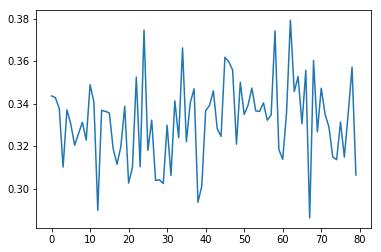

Epoch  6 Summary:  Training_auc : 0.760926604403216  , Validation_auc :  0.7508027083922949  ,Test_auc :  0.7540657724837955 Test_auc on short visits: 0.7254631736086554 Test_auc on long visits: 0.7828964327892838  Avg Loss:  0.3318725772646912 Train Time (2m 10s) Eval Time (1m 6s)

 Current running on: Epoch  7 Training loss:  Average loss 0.33164750632934503


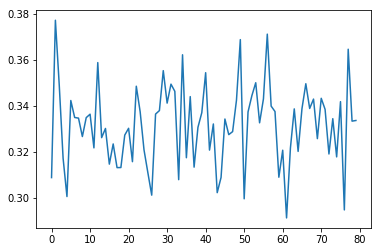

Epoch  7 Summary:  Training_auc : 0.76157240939183  , Validation_auc :  0.7512749589912965  ,Test_auc :  0.7524226696760554 Test_auc on short visits: 0.7292051006732648 Test_auc on long visits: 0.7766853896650877  Avg Loss:  0.33164750632934503 Train Time (1m 59s) Eval Time (1m 6s)

 Current running on: Epoch  8 Training loss:  Average loss 0.3311018248090984


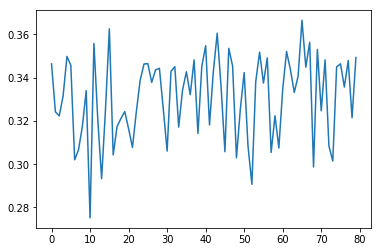

Epoch  8 Summary:  Training_auc : 0.7566503585946722  , Validation_auc :  0.7479786505231506  ,Test_auc :  0.7522240392001933 Test_auc on short visits: 0.7283566150270907 Test_auc on long visits: 0.7763100717089108  Avg Loss:  0.3311018248090984 Train Time (2m 49s) Eval Time (1m 6s)

 Current running on: Epoch  9 Training loss:  Average loss 0.3317915281254574


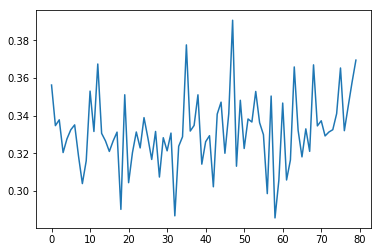

Epoch  9 Summary:  Training_auc : 0.758958398918337  , Validation_auc :  0.7522050242701663  ,Test_auc :  0.7535781739167695 Test_auc on short visits: 0.7304435767721812 Test_auc on long visits: 0.7767093848948827  Avg Loss:  0.3317915281254574 Train Time (1m 59s) Eval Time (1m 6s)

 Current running on: Epoch  10 Training loss:  Average loss 0.3319683252493782


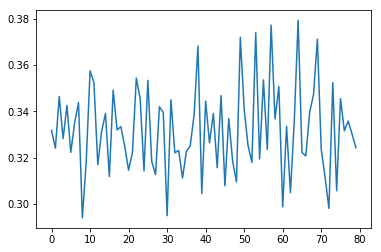

Epoch  10 Summary:  Training_auc : 0.7631351018325739  , Validation_auc :  0.7579421436876537  ,Test_auc :  0.7522671833261647 Test_auc on short visits: 0.7265240694574361 Test_auc on long visits: 0.7773242675039387  Avg Loss:  0.3319683252493782 Train Time (2m 4s) Eval Time (1m 2s)

 Current running on: Epoch  11 Training loss:  Average loss 0.331588636916606


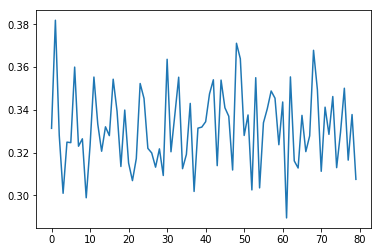

Epoch  11 Summary:  Training_auc : 0.7590879992945326  , Validation_auc :  0.7543651367919181  ,Test_auc :  0.7504826104876154 Test_auc on short visits: 0.726357515775168 Test_auc on long visits: 0.7747761989338674  Avg Loss:  0.331588636916606 Train Time (2m 2s) Eval Time (1m 1s)

 Current running on: Epoch  12 Training loss:  Average loss 0.33139128587392175


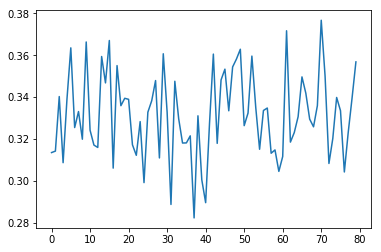

Epoch  12 Summary:  Training_auc : 0.7647841794836622  , Validation_auc :  0.7580651163321216  ,Test_auc :  0.7561057313069239 Test_auc on short visits: 0.7294639624808251 Test_auc on long visits: 0.7827162553610345  Avg Loss:  0.33139128587392175 Train Time (2m 4s) Eval Time (1m 3s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3316772443089455


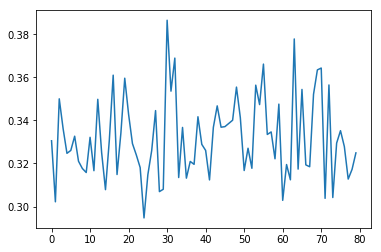

Epoch  13 Summary:  Training_auc : 0.7614221789388566  , Validation_auc :  0.7542018505066117  ,Test_auc :  0.7527773570939178 Test_auc on short visits: 0.7338280680129907 Test_auc on long visits: 0.7739008188381858  Avg Loss:  0.3316772443089455 Train Time (2m 2s) Eval Time (1m 40s)

 Current running on: Epoch  14 Training loss:  Average loss 0.3315026408581053


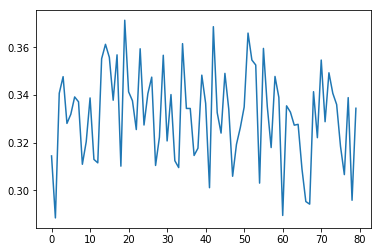

Epoch  14 Summary:  Training_auc : 0.7617024129014728  , Validation_auc :  0.7519409360606409  ,Test_auc :  0.752118332410324 Test_auc on short visits: 0.7267101209120924 Test_auc on long visits: 0.7764147746421513  Avg Loss:  0.3315026408581053 Train Time (1m 58s) Eval Time (1m 3s)

 Current running on: Epoch  15 Training loss:  Average loss 0.3317936195564137


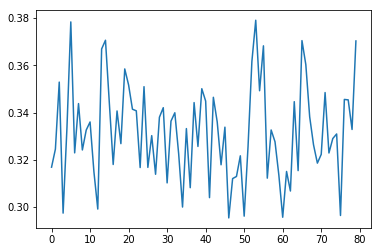

Epoch  15 Summary:  Training_auc : 0.7603961776865954  , Validation_auc :  0.7543672754466045  ,Test_auc :  0.7530499896851671 Test_auc on short visits: 0.7306126858177965 Test_auc on long visits: 0.7760264705761499  Avg Loss:  0.3317936195564137 Train Time (2m 3s) Eval Time (1m 2s)

 Current running on: Epoch  16 Training loss:  Average loss 0.33148591484509443


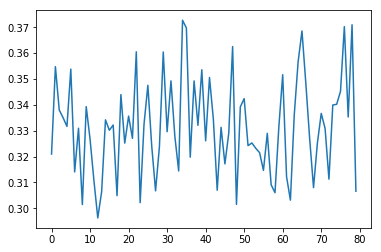

Epoch  16 Summary:  Training_auc : 0.7604454568671266  , Validation_auc :  0.7539377622970863  ,Test_auc :  0.7521368306383962 Test_auc on short visits: 0.7299571476068183 Test_auc on long visits: 0.7743890190385675  Avg Loss:  0.33148591484509443 Train Time (2m 4s) Eval Time (1m 1s)

 Current running on: Epoch  17 Training loss:  Average loss 0.331559425845011


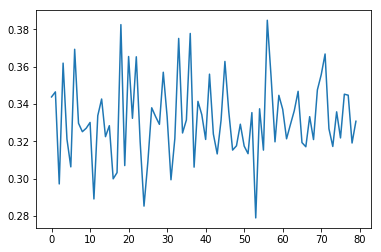

Epoch  17 Summary:  Training_auc : 0.7634629114595213  , Validation_auc :  0.7572424828069986  ,Test_auc :  0.7544331877869435 Test_auc on short visits: 0.7305128166173949 Test_auc on long visits: 0.7783045443553955  Avg Loss:  0.331559425845011 Train Time (2m 22s) Eval Time (1m 16s)

 Current running on: Epoch  18 Training loss:  Average loss 0.33224676024960564


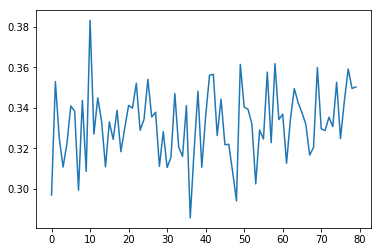

Epoch  18 Summary:  Training_auc : 0.7616218949470984  , Validation_auc :  0.7527847066229145  ,Test_auc :  0.7547262880693534 Test_auc on short visits: 0.7262298876277218 Test_auc on long visits: 0.781059847979559  Avg Loss:  0.33224676024960564 Train Time (1m 58s) Eval Time (1m 4s)

 Current running on: Epoch  19 Training loss:  Average loss 0.3317655058780897


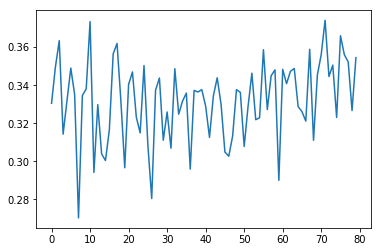

Epoch  19 Summary:  Training_auc : 0.7637427666986054  , Validation_auc :  0.7541647092035577  ,Test_auc :  0.7552095611800641 Test_auc on short visits: 0.7286883221925324 Test_auc on long visits: 0.7810103069396919  Avg Loss:  0.3317655058780897 Train Time (2m 3s) Eval Time (1m 4s)


In [11]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [12]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

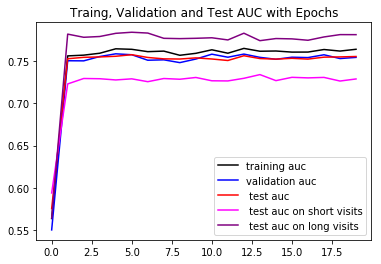

In [13]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [14]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim1_largeData_Exclast')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/30/training-auc-validation-auc-test-auc-test-auc-on-5-visits/>**

Or you can see a static plot here:

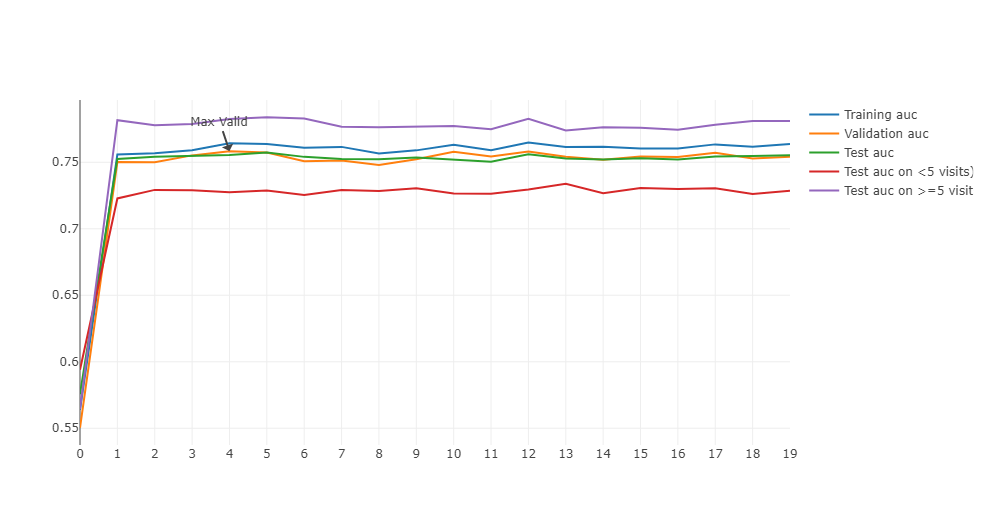

In [1]:
from IPython.display import Image
Image('img/LR_Auc_dim1_largeData_Exclast.png')

In [15]:
#extract weights
torch.save(ehr_model, 'Lr1model_dim1_largeData_ExcLast')
z= pd.DataFrame(ehr_model.embedding.weight.cpu().data.numpy())
z.to_csv('embedding weights_dim1_largedata_excLast')
ehr_model.embedding.weight

Parameter containing:
-2.2599e-10
 3.7250e-02
 7.0696e-02
     ⋮      
 7.9810e-17
 8.7304e-18
 5.8387e-06
[torch.cuda.FloatTensor of size 20000x1 (GPU 0)]